# 批量归一化
- 在dnn里，数据（底层）离损失函数（上层）很远，反向传播时，梯度在损失函数比较大，越到下面越小
    - 梯度是n个很小的数相乘，越往后，梯度值越小，对权重的更新也就小
    - 导致上层收敛快，底层收敛慢。当底层权重更新时，上层权重也要重新训练。
    - 最终导致整体网络收敛变慢
- 需求：在学习底部的时候，避免顶部不断的变化
<img src="./pic/批量归一化.PNG" width=400 height=400>
- 这里的变化指的是不同batch的分布变化，而不是指底层参数变化导致顶层参数变化


## 批量归一化思想：尝试把小批量在不同层的输入与输出的均值和方差固定住
- 假设输出和梯度符合某一个分布，相对来说比较稳定
    - B：每个小批量的索引
    - x<sub>i</sub>：与索引对应的样本
    - μ：对小批量的样本求和，再除以批量大小，得到均值。
    - σ<sup>2</sup>：在小批量里，每个的样本与均值的差的平方，再减ε得到方差
    - ε：很小的数，防止方差变成0
- 得到均值和方差后，再做批量归一化
    - 样本x<sub>i</sub> 减去均值，除以标准差，再乘以γ，加上β
    - μ与σ是根据当前数据计算出来的
    - γ与β是可学习的参数
    - 意义：假如均值为0，方差为1的分布不合适，则可以通过学习一个新的方差和均值，使分布稳定
<img src="./pic/批量归一化思想.PNG" width=400 height=400>


## 批量归一化层
- 线性变换，在激活函数之前。用来防止分布剧烈变化
- <img src="./pic/批量归一化层.PNG" width=400 height=400>
- 对于全连接层，作用在特征维上
    - 输入是一个二维的矩阵，每一行就是一个样本，每一列就是一个特征，
    - 对每一个特征，计算标量的均值和方差，再用学到的γ与β对方差和均值进行矫正
- 重点：对于卷积层，作用在通道维。
    - 把每个像素，假设单个像素的通道数为100，则该像素有一个长为100维的向量
    - 100维的向量，表示这个像素的有100个特征
    - 对于一个有高宽的输入来说，每个像素是一个样本
    - 对于卷积层，输入形状是（批量大小，通道数，高，宽）
        - 样本数为（批量大小x高x宽）
        - **在每个批量里，1个像素是1个样本。与像素（样本）对应的通道维，就是特征维**
        
        
## 批量归一化在做什么
<img src="./pic/批量归一化在做什么1.PNG" width=400 height=400>


## 总结
- 批量归一化固定小批量中的均值和方差，然后学习出适合的偏移和缩放
    - 防止**学习率**太大，导致上层网络梯度爆炸
    - 防止**学习率**太小，导致底层网络梯度消失，算不动
- 可以加速收敛速度，但一般不改变模型精度

# 2. 批量归一化，从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # moving_mean & moving_var整个数据集（全局）的均值的方差，不是小批量的
            # 因为做推理的时候，没有批量
    # eps: 防止方差等于0，固定值
    # momentum 用来更新 moving_mean & moving_var，通常取0.9
    
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():    # if not：不要算梯度，就是做推理
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)    # 形状要么等于2，全连接层；要么等于4，卷积层
        # 2表示有两个维度，样本和特征；4表示有4个维度，(输入通道，输出通道，高，宽)
        # 以下mean和var是当前批量的均值和方差
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)    # 按行求均值：对每一列，算一个均值出来，1 x n的行向量
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)    # 0批量，2高，3宽。对1通道求平均=（1x n x1x1）
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)    # 
        # 更新移动平均的均值和方差（卡尔曼滤波）
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [18]:
a = torch.arange(27.).view(3,3,3)
a_mean = a.mean(dim=0)
a_var = ((a - a_mean) ** 2).mean(dim=0)
a, a.shape, a_mean, a_mean.shape, a_var, a_var.shape

(tensor([[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],
 
         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]],
 
         [[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]]]),
 torch.Size([3, 3, 3]),
 tensor([[ 9., 10., 11.],
         [12., 13., 14.],
         [15., 16., 17.]]),
 torch.Size([3, 3]),
 tensor([[54., 54., 54.],
         [54., 54., 54.],
         [54., 54., 54.]]),
 torch.Size([3, 3]))

## 创建一个正确的BatchNorm层

In [20]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))    # 要去拟合方差，不能torch.zero，不然都为0
        self.beta = nn.Parameter(torch.zeros(shape))    # 要去拟合均值
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 使用批量规范化层的 LeNet
- 应用BatchNorm与LeNet模型

In [21]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), # feature数等于通道数6。因为是卷积，所以是4D
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2),    # 因为是全连接，所以是2D
    nn.Sigmoid(),    
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

- 在Fashion-MNIST数据集上训练网络

loss 0.268, train acc 0.902, test acc 0.870
37724.2 examples/sec on cuda:0


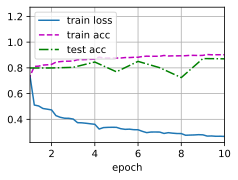

In [22]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

- 看看从第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta

In [23]:
# 第一个batch norm的gamma和beta：

net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.1402, 1.6200, 3.0593, 4.0298, 3.0949, 2.7144], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([ 2.5808, -1.4412, -2.2911, -2.2372, -0.4282,  2.8837], device='cuda:0',
        grad_fn=<ViewBackward>))

In [25]:
net[1].gamma.shape

torch.Size([1, 6, 1, 1])

## BN层的简洁实现

In [26]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), # 不需要指定（2或4）维度，只用指定通道数
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120),       # 指定特征值的数量 
    nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.275, train acc 0.899, test acc 0.859
63757.6 examples/sec on cuda:0


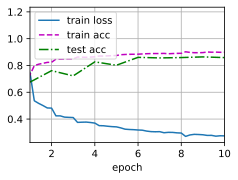

In [27]:
# 使用相同超参数来训练模型
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Q：BN是做了线性变换，和加一个线性层有什么区别？
A：加了一个线性层，但线性层不一定能学到想要的东西。如果不对数据做特征预处理，很有可能数值不稳定，不能训练到好的值域里面去

Q：为什么bn会使收敛时间变短？
A：加了bn后，使梯度值增大一点，且每个梯度的值，会差不多，可以使用更大的学习率